In [1]:
from importlib import import_module
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import seaborn as sb

In [2]:
# Specify the run ID (aka problem name).
runid = "linecurrent_BxBy"

# Add the subdirectory for the run results to the module search path.
run_path = os.path.join(".", runid)
sys.path.append(run_path)

# Import the problem definition from the run results directory.
p = import_module(runid)

# Read the run hyperparameters from the run results directory.
import hyperparameters as hp

2023-02-05 18:29:35.453269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Analytical solution

# Constants
mu0 = 1.0  # Normalized vacuum permittivity.
I = 1.0    # Normalized current.
Q = 60.0   # Flow angle in degrees clockwise from +y axis.
u0 = 1.0   # Initial flow speed.

# Compute the constant velocity components.
ux = u0*np.sin(np.radians(Q))
uy = u0*np.cos(np.radians(Q))

def Bx_analytical(t, x, y):
    r = np.sqrt((x - ux*t)**2 + (y - uy*t)**2)
    Bx = -mu0*I/(2*np.pi)*(y - uy*t)/r**2
    return Bx

def By_analytical(t, x, y):
    r = np.sqrt((x - ux*t)**2 + (y - uy*t)**2)
    By = mu0*I/(2*np.pi)*(x - ux*t)/r**2
    return By

In [4]:
# Load the training points.
txy_train = np.loadtxt(os.path.join(runid, "X_train.dat"))
t_train = txy_train[:, 0]
x_train = txy_train[:, 1]
y_train = txy_train[:, 2]

# Compute the data limits.
t_min = t_train[0]
t_max = t_train[-1]
x_min = x_train[0]
x_max = x_train[-1]
y_min = y_train[0]
y_max = y_train[-1]

In [5]:
# Extract the unique training point values (a grid is assumed).
t_train_vals = np.unique(t_train)
x_train_vals = np.unique(x_train)
y_train_vals = np.unique(y_train)
n_t_train_vals = len(t_train_vals)
n_x_train_vals = len(x_train_vals)
n_y_train_vals = len(y_train_vals)

In [6]:
# Compute the heat map tick locations and labels.
n_x_ticks = 6
x_tick_pos = np.linspace(0, n_x_train_vals - 1, n_x_ticks)
x_tick_labels = ["%.2f" % (x_min + x/(n_x_train_vals - 1)*(x_max - x_min)) for x in x_tick_pos]
n_y_ticks = 6
y_tick_pos = np.linspace(0, n_y_train_vals - 1, n_y_ticks)
y_tick_labels = ["%.2f" % (y_min + y/(n_y_train_vals - 1)*(y_max - y_min)) for y in y_tick_pos]
y_tick_labels = list(reversed(y_tick_labels))

In [7]:
# Load the data locations and values.
txy_data = np.loadtxt(os.path.join(runid, "XY_data.dat"))

In [8]:
# Load the model-predicted values.
ψ = []
delψ = []
for i in range(len(p.dependent_variable_names)):
    var_name = p.dependent_variable_names[i]
    ψ.append(np.loadtxt(os.path.join(runid, "%s_train.dat" % var_name)))
    delψ.append(np.loadtxt(os.path.join(runid, "del_%s_train.dat" % var_name)))

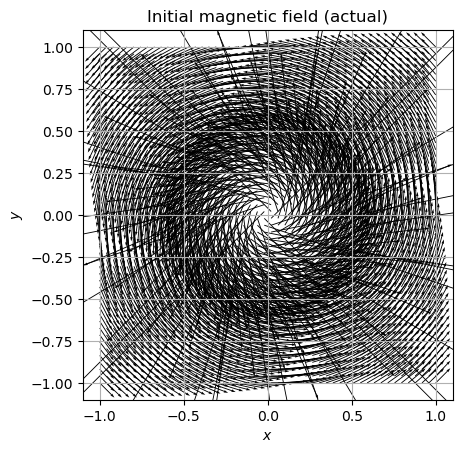

In [9]:
# Plot the actual initial magnetic field as a quiver plot.
x = txy_data[:, 1]
y = txy_data[:, 2]
B0x_act = txy_data[:, 3]
B0y_act = txy_data[:, 4]
plt.quiver(x, y, B0x_act, B0y_act, scale=2)
ax = plt.gca()
ax.set_aspect(1.0)
ax.grid()
plt.title("Initial magnetic field (actual)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

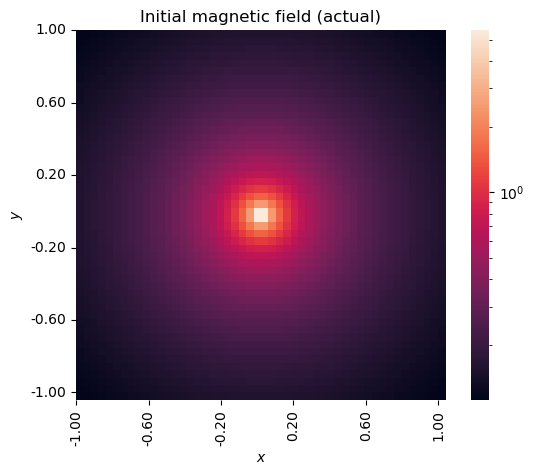

In [10]:
# Plot the actual initial magnetic field as a logarithmic heat map.
# These data were generated with the analytical solution.
B0x_act = txy_data[:, 3]
B0y_act = txy_data[:, 4]
B0_act = np.sqrt(B0x_act**2 + B0y_act**2)
# To get the proper orientation, reshape, transpose, flip.
B0_act = np.flip(B0_act.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
sb.heatmap(B0_act, norm=LogNorm(), square=True)
plt.xticks(x_tick_pos, x_tick_labels)
plt.yticks(y_tick_pos, y_tick_labels)
plt.title("Initial magnetic field (actual)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

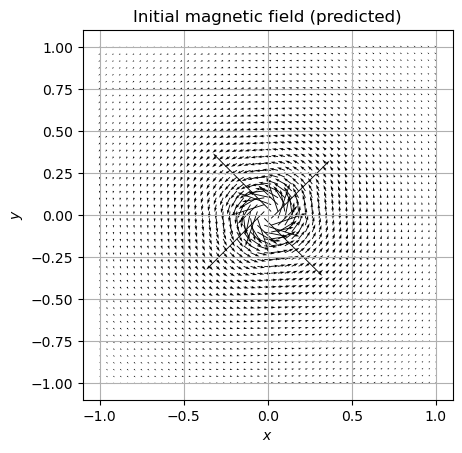

In [11]:
# Plot the predicted initial magnetic field as a quiver plot.
n_start = n_x_train_vals*n_y_train_vals
x = x_train[:n_start]
y = y_train[:n_start]
B0x_pred = ψ[0][:n_start]
B0y_pred = ψ[1][:n_start]
plt.quiver(x, y, B0x_pred, B0y_pred)
ax = plt.gca()
ax.set_aspect(1.0)
ax.grid()
plt.title("Initial magnetic field (predicted)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

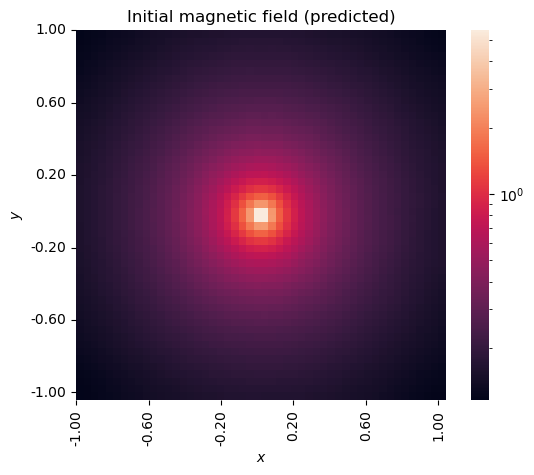

In [12]:
# Plot the predicted initial magnetic field as a logarithmic heat map.
n_start = n_x_train_vals*n_y_train_vals
x = x_train[:n_start]
y = y_train[:n_start]
B0x_pred = ψ[0][:n_start]
B0y_pred = ψ[1][:n_start]
B0_pred = np.sqrt(B0x_pred**2 + B0y_pred**2)
# To get the proper orientation, reshape, transpose, flip.
B0_pred = np.flip(B0_pred.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
sb.heatmap(B0_pred, norm=LogNorm(), square=True)
plt.xticks(x_tick_pos, x_tick_labels)
plt.yticks(y_tick_pos, y_tick_labels)
plt.title("Initial magnetic field (predicted)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

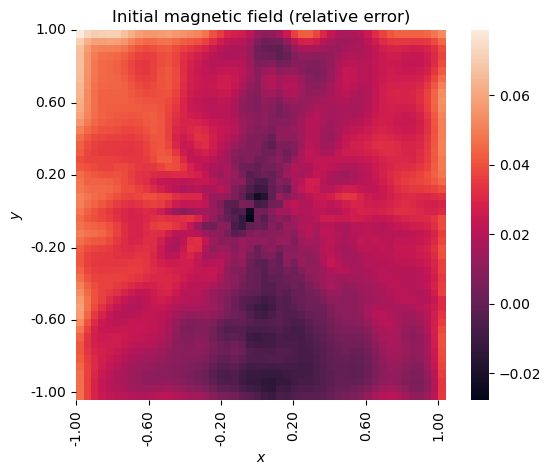

In [13]:
# Plot the error in the predicted initial magnetic field as a heat map.
n_start = n_x_train_vals*n_y_train_vals
x = x_train[:n_start]
y = y_train[:n_start]
B0_err = (B0_pred - B0_act)/B0_act
# To get the proper orientation, reshape, transpose, flip.
B0_err = np.flip(B0_err.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
sb.heatmap(B0_err, square=True)
plt.xticks(x_tick_pos, x_tick_labels)
plt.yticks(y_tick_pos, y_tick_labels)
plt.title("Initial magnetic field (relative error)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

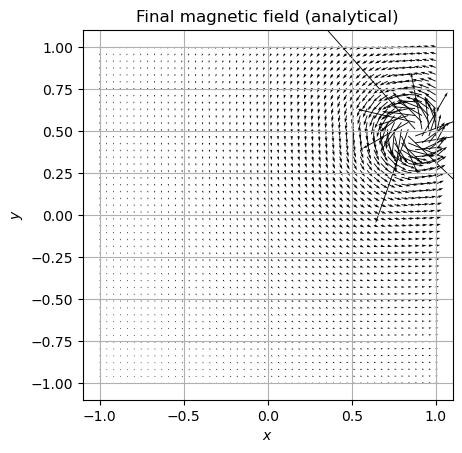

In [14]:
# Plot the analytical final magnetic field as a quiver plot.
n_end = n_x_train_vals*n_y_train_vals
t = t_train[-n_end:]
x = x_train[-n_end:]
y = y_train[-n_end:]
B1x_act = Bx_analytical(t, x, y)
B1y_act = By_analytical(t, x, y)
plt.quiver(x, y, B1x_act, B1y_act)
ax = plt.gca()
ax.set_aspect(1.0)
ax.grid()
plt.title("Final magnetic field (analytical)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

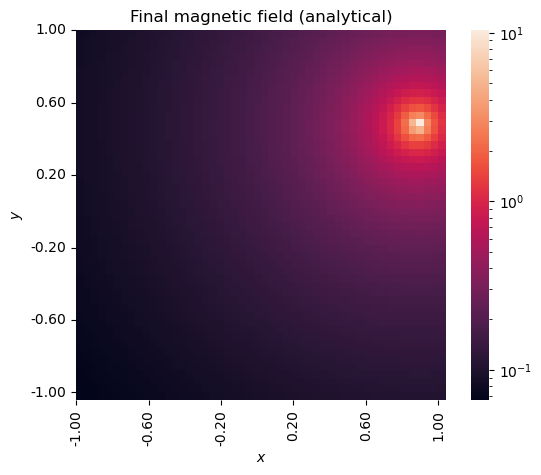

In [15]:
# Plot the analytical final magnetic field as a logarithmic heat map.
n_end = n_x_train_vals*n_y_train_vals
t = t_train[-n_end:]
x = x_train[-n_end:]
y = y_train[-n_end:]
B1x_act = Bx_analytical(t, x, y)
B1y_act = By_analytical(t, x, y)
B1_act = np.sqrt(B1x_act**2 + B1y_act**2)
# To get the proper orientation, reshape, transpose, flip.
B1_act = np.flip(B1_act.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
sb.heatmap(B1_act, norm=LogNorm(), square=True)
plt.xticks(x_tick_pos, x_tick_labels)
plt.yticks(y_tick_pos, y_tick_labels)
plt.title("Final magnetic field (analytical)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

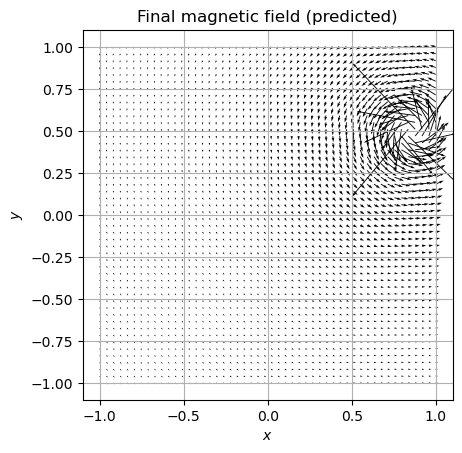

In [16]:
# Plot the predicted final magnetic field as a quiver plot.
n_end = n_x_train_vals*n_y_train_vals
x = x_train[-n_end:]
y = y_train[-n_end:]
B1x_pred = ψ[0][-n_end:]
B1y_pred = ψ[1][-n_end:]
plt.quiver(x, y, B1x_pred, B1y_pred)
ax = plt.gca()
ax.set_aspect(1.0)
ax.grid()
plt.title("Final magnetic field (predicted)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

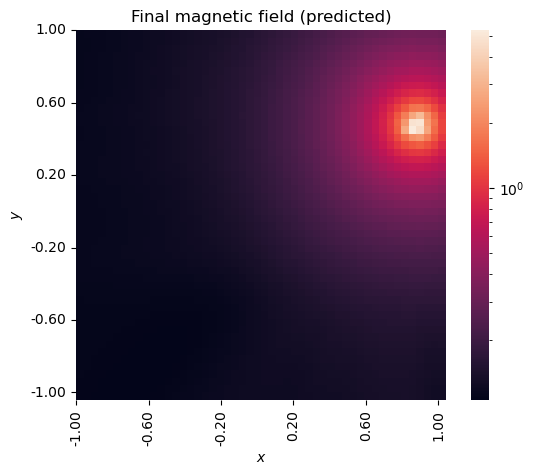

In [17]:
# Plot the predicted final magnetic field as a logarithmic heat map.
n_end = n_x_train_vals*n_y_train_vals
x = x_train[-n_end:]
y = y_train[-n_end:]
B1x_pred = ψ[0][-n_end:]
B1y_pred = ψ[1][-n_end:]
B1_pred = np.sqrt(B1x_pred**2 + B1y_pred**2)
# To get the proper orientation, reshape, transpose, flip.
B1_pred = np.flip(B1_pred.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
sb.heatmap(B1_pred, norm=LogNorm(), square=True)
plt.xticks(x_tick_pos, x_tick_labels)
plt.yticks(y_tick_pos, y_tick_labels)
plt.title("Final magnetic field (predicted)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()

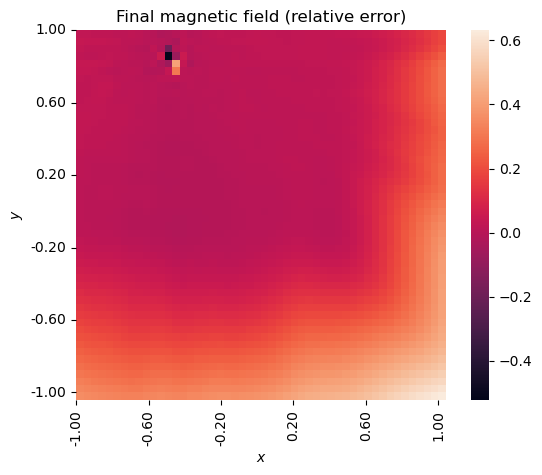

In [18]:
# Plot the error in the predicted final magnetic field as a heat map.
n_end = n_x_train_vals*n_y_train_vals
x = x_train[-n_end:]
y = y_train[-n_end:]
B1_err = (B1_pred - B1_act)/B1_act
# To get the proper orientation, reshape, transpose, flip.
B1_err = np.flip(B1_err.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
sb.heatmap(B1_err, square=True)
plt.xticks(x_tick_pos, x_tick_labels)
plt.yticks(y_tick_pos, y_tick_labels)
plt.title("Final magnetic field (relative error)")
plt.xlabel(p.independent_variable_labels[1])
plt.ylabel(p.independent_variable_labels[2])
plt.show()